In [ ]:
请参考https://mindspore.cn/mindquantum/docs/zh-CN/master/quantum_approximate_optimization_algorithm.html
完成如下图的MaxCut问题

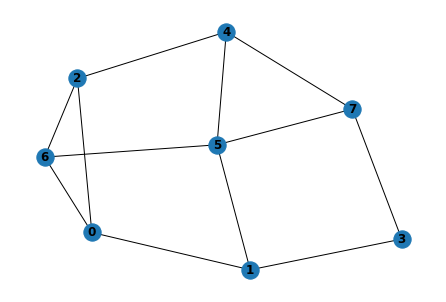

In [1]:
import networkx as nx
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [0, 2])
nx.add_path(g, [1, 3])
nx.add_path(g, [2, 4])
nx.add_path(g, [4, 5])
nx.add_path(g, [4, 7])
nx.add_path(g, [5, 6])
nx.add_path(g, [6, 2])
nx.add_path(g, [7, 4])
nx.add_path(g, [1, 5])
nx.add_path(g, [0, 6])
nx.add_path(g, [5, 7])
nx.add_path(g, [7, 3])
nx.draw(g, with_labels=True, font_weight='bold')


In [2]:
from mindquantum.core import Circuit, Hamiltonian, UN, H, ZZ, RX, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

In [3]:
def build_hc(g, para):
    hc = Circuit()
    for i in g.edges:
        hc += ZZ(para).on(i)
    hc.barrier()
    return hc

def build_hb(g, para):
    hb = Circuit()
    for i in g.nodes:
        hb += RX(para).on(i)
    hb.barrier()
    return hb

In [4]:
circuit = build_hc(g,'gamma')
circuit.svg()

In [5]:
circuit = build_hb(g, 'bata')
circuit.svg()

In [6]:
circuit = build_hc(g, 'gamma') + build_hb(g, 'beta')
circuit.svg()

In [8]:
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'g{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ
    
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

In [9]:
p = 4
ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(g, p)                  # 生成ansatz线路
circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
circ.svg()

In [12]:
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)                     # 创建模拟器，backend使用‘projectq’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练
for i in range(200):
    cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i%10 == 0:
        print("train step:", i, ", cut:", cut)  # 每训练10步，打印当前训练步数和当前得到的切割边数
        

[WARNING] DEBUG(595,7f93de86d740,python):2022-06-20-07:47:39.941.396 [mindspore/ccsrc/debug/debugger/debugger.cc:95] Debugger] Not enabling debugger. Debugger does not support CPU.
train step: 0 , cut: [5.997428]
train step: 10 , cut: [8.272647]
train step: 20 , cut: [8.978292]
train step: 30 , cut: [9.357523]
train step: 40 , cut: [9.423102]
train step: 50 , cut: [9.504919]
train step: 60 , cut: [9.534615]
train step: 70 , cut: [9.53803]
train step: 80 , cut: [9.544916]
train step: 90 , cut: [9.544322]
train step: 100 , cut: [9.544965]
train step: 110 , cut: [9.545113]
train step: 120 , cut: [9.545177]
train step: 130 , cut: [9.545206]
train step: 140 , cut: [9.545204]
train step: 150 , cut: [9.545207]
train step: 160 , cut: [9.545208]
train step: 170 , cut: [9.545208]
train step: 180 , cut: [9.545208]
train step: 190 , cut: [9.545208]


In [16]:
pr = dict(zip(ansatz.params_name, net.weight.asnumpy())) # 获取线路参数
print(pr)
circ.measure_all()                               # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()      # 运行线路1000次并打印结果

{'g0': -0.17906594, 'b0': 1.1260065, 'g1': -0.3578009, 'b1': 0.85863096, 'g2': -0.42885974, 'b2': 0.62867063, 'g3': -0.4833478, 'b3': 0.3198719}


ValueError: measure key q0 already exist.

In [ ]:
'''
    传统方法对比
'''
